In [ ]:
import pandas as pd
import numpy as np
import time
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


MODEL COMPARISON: CatBoost vs Random Forest vs XGBoost


# 1. LOAD YOUR PREPROCESSED DATA

In [ ]:
df = pd.read_csv('recs2020_public_v7.csv')  
TARGET = 'TOTALBTU'
    

valid_idx = df[TARGET].notna() & (df[TARGET] > 0)
df = df[valid_idx].reset_index(drop=True)
    
feature_cols = [col for col in df.columns if col != TARGET]
X = df[feature_cols]
y = df[TARGET]
    
# Train-test split
from sklearn.model_selection import train_test_split
n_bins = 10
y_binned = pd.qcut(y, q=n_bins, labels=False, duplicates='drop')
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.10, random_state=RANDOM_STATE, stratify=y_binned
)
    
print(f"\nData loaded and split:")
print(f"Training: {X_train.shape}")
print(f"Test: {X_test.shape}")


Data loaded and split:
Training: (16646, 798)
Test: (1850, 798)


 2. PREPARE DATA FOR DIFFERENT MODELS

In [ ]:
# Identify categorical features in data
categorical_candidates = []
climate_features = ['BA_climate', 'IECC_climate_code']
building_type_features = ['TYPEHUQ', 'STORIES', 'KOWNRENT']
equipment_categorical = ['EQUIPM', 'FUELHEAT', 'EQUIPAUXTYPE', 'EQUIPAUX',
                        'ACEQUIPM_PUB', 'ACEQUIPAUXTYPE_PUB', 'FUELH2O']
usage_categorical = ['ATHOME', 'ZATHOME', 'TELLWORK']
building_char_features = ['YEARMADERANGE']
building_categorical = ['ADQINSUL', 'ATTIC', 'ATTICFIN', 'ATTICFAN', 'BASEFIN',
                       'TYPEGLASS', 'WINFRAME', 'ORIGWIN']

all_categorical = (climate_features + building_type_features + equipment_categorical + 
                   usage_categorical + building_char_features + building_categorical)


categorical_features = [f for f in all_categorical if f in X_train.columns]


for col in X_train.columns:
    if col not in categorical_features:
       
        if X_train[col].dtype == 'object' or X_train[col].dtype.name == 'category':
            categorical_features.append(col)

# Remove duplicates
categorical_features = list(set(categorical_features))

print(f"\nFeature Analysis:")
print(f"Total features: {len(X_train.columns)}")
print(f"Categorical features detected: {len(categorical_features)}")
print(f"Numerical features: {len(X_train.columns) - len(categorical_features)}")
print(f"\nCategorical features list:")
for cat_feat in sorted(categorical_features):
    print(f"  - {cat_feat}")

# For Random Forest and XGBoost: encode categorical variables

print("Encoding categorical variables for Random Forest and XGBoost...")
print("="*80)

X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
  
    train_vals = X_train[col].fillna('MISSING').astype(str)
    test_vals = X_test[col].fillna('MISSING').astype(str)
    combined = pd.concat([train_vals, test_vals])
    
    le.fit(combined)
    X_train_encoded[col] = le.transform(train_vals)
    X_test_encoded[col] = le.transform(test_vals)
    label_encoders[col] = le

print(f"✓ Encoded {len(categorical_features)} categorical features")


Feature Analysis:
Total features: 798
Categorical features detected: 29
Numerical features: 769

Categorical features list:
  - ACEQUIPAUXTYPE_PUB
  - ACEQUIPM_PUB
  - ADQINSUL
  - ATHOME
  - ATTIC
  - ATTICFAN
  - ATTICFIN
  - BASEFIN
  - BA_climate
  - DIVISION
  - EQUIPAUX
  - EQUIPAUXTYPE
  - EQUIPM
  - FUELH2O
  - FUELHEAT
  - IECC_climate_code
  - KOWNRENT
  - ORIGWIN
  - REGIONC
  - STORIES
  - TELLWORK
  - TYPEGLASS
  - TYPEHUQ
  - UATYP10
  - WINFRAME
  - YEARMADERANGE
  - ZATHOME
  - state_name
  - state_postal

Encoding categorical variables for Random Forest and XGBoost...
✓ Encoded 29 categorical features


3. DEFINE MODELS

In [6]:
models = {
    'CatBoost': {
        'model': CatBoostRegressor(
            iterations=1500,
            learning_rate=0.03,
            depth=8,
            l2_leaf_reg=5,
            loss_function='RMSE',
            random_seed=RANDOM_STATE,
            verbose=False,
            early_stopping_rounds=100,
            use_best_model=True,
            bootstrap_type='Bayesian',
            bagging_temperature=1
        ),
        'uses_pool': True,
        'X_train': X_train,
        'X_test': X_test
    },
    
    'Random Forest': {
        'model': RandomForestRegressor(
            n_estimators=500,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt',
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbose=0
        ),
        'uses_pool': False,
        'X_train': X_train_encoded,
        'X_test': X_test_encoded
    },
    
    'XGBoost': {
        'model': XGBRegressor(
            n_estimators=1500,
            learning_rate=0.03,
            max_depth=8,
            reg_lambda=5,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            early_stopping_rounds=100,
            eval_metric='mae'
        ),
        'uses_pool': False,
        'X_train': X_train_encoded,
        'X_test': X_test_encoded
    }
}


4. TRAIN AND EVALUATE MODELS

In [ ]:
results = {
    'Model': [],
    'Training_Time': [],
    'Prediction_Time': [],
    'MAE': [],
    'RMSE': [],
    'R2': [],
    'MAPE': []
}

predictions = {}

print("TRAINING AND EVALUATING MODELS")
print("="*80)

for model_name, config in models.items():
    print(f"Training: {model_name}")
    print(f"{'='*80}")
    
    model = config['model']
    X_tr = config['X_train']
    X_te = config['X_test']
    
    # Training
    start_time = time.time()
    
    if config['uses_pool']:
     
        train_pool = Pool(X_tr, y_train, cat_features=categorical_features)
        test_pool = Pool(X_te, y_test, cat_features=categorical_features)
        model.fit(train_pool, eval_set=test_pool)
    else:
 
        if model_name == 'XGBoost':
            model.fit(
                X_tr, y_train,
                eval_set=[(X_te, y_test)],
                verbose=False
            )
        else:
            model.fit(X_tr, y_train)
    
    training_time = time.time() - start_time
    
    # Prediction
    start_time = time.time()
    y_pred = model.predict(X_te)
    prediction_time = time.time() - start_time
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    # Store results
    results['Model'].append(model_name)
    results['Training_Time'].append(training_time)
    results['Prediction_Time'].append(prediction_time)
    results['MAE'].append(mae)
    results['RMSE'].append(rmse)
    results['R2'].append(r2)
    results['MAPE'].append(mape)
    
    predictions[model_name] = y_pred
    
    # Print results
    print(f"\nResults:")
    print(f"  Training Time:   {training_time:.2f} seconds")
    print(f"  Prediction Time: {prediction_time:.4f} seconds")
    print(f"  MAE:             {mae:,.0f} BTU")
    print(f"  RMSE:            {rmse:,.0f} BTU")
    print(f"  R²:              {r2:.4f}")
    print(f"  MAPE:            {mape:.2f}%")


TRAINING AND EVALUATING MODELS

Training: CatBoost

Results:
  Training Time:   183.31 seconds
  Prediction Time: 0.0370 seconds
  MAE:             1,327 BTU
  RMSE:            4,216 BTU
  R²:              0.9932
  MAPE:            1.74%

Training: Random Forest

Results:
  Training Time:   17.11 seconds
  Prediction Time: 0.1452 seconds
  MAE:             6,261 BTU
  RMSE:            11,277 BTU
  R²:              0.9511
  MAPE:            9.39%

Training: XGBoost

Results:
  Training Time:   75.28 seconds
  Prediction Time: 0.1553 seconds
  MAE:             1,753 BTU
  RMSE:            5,345 BTU
  R²:              0.9890
  MAPE:            2.04%


5. COMPARE RESULTS

In [ ]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('R2', ascending=False)

print("COMPARISON SUMMARY")
print("="*80)
print(results_df.to_string(index=False))

# Find best model
best_model_r2 = results_df.iloc[0]['Model']
best_model_mae = results_df.loc[results_df['MAE'].idxmin(), 'Model']

print(f"\n{'='*80}")
print(f"Best Model by R²:  {best_model_r2} (R² = {results_df.iloc[0]['R2']:.4f})")
print(f"Best Model by MAE: {best_model_mae} (MAE = {results_df['MAE'].min():,.0f} BTU)")
print(f"{'='*80}")

# Calculate percentage differences from best
print(f"\nPerformance relative to best model ({best_model_r2}):")
best_r2 = results_df.iloc[0]['R2']
best_mae = results_df['MAE'].min()

for idx, row in results_df.iterrows():
    if row['Model'] != best_model_r2:
        r2_diff = ((best_r2 - row['R2']) / best_r2) * 100
        mae_diff = ((row['MAE'] - best_mae) / best_mae) * 100
        print(f"  {row['Model']:15s}: R² is {r2_diff:.1f}% worse, MAE is {mae_diff:.1f}% worse")


COMPARISON SUMMARY
        Model  Training_Time  Prediction_Time         MAE         RMSE       R2     MAPE
     CatBoost     183.312218         0.036990 1326.743334  4215.800024 0.993172 1.737272
      XGBoost      75.275736         0.155257 1753.001839  5345.258142 0.989024 2.043262
Random Forest      17.113885         0.145215 6261.060528 11277.379973 0.951144 9.387364

Best Model by R²:  CatBoost (R² = 0.9932)
Best Model by MAE: CatBoost (MAE = 1,327 BTU)

Performance relative to best model (CatBoost):
  XGBoost        : R² is 0.4% worse, MAE is 32.1% worse
  Random Forest  : R² is 4.2% worse, MAE is 371.9% worse


6. VISUALIZATIONS


GENERATING COMPARISON VISUALIZATIONS
Visualizations saved as 'model_comparison.png'


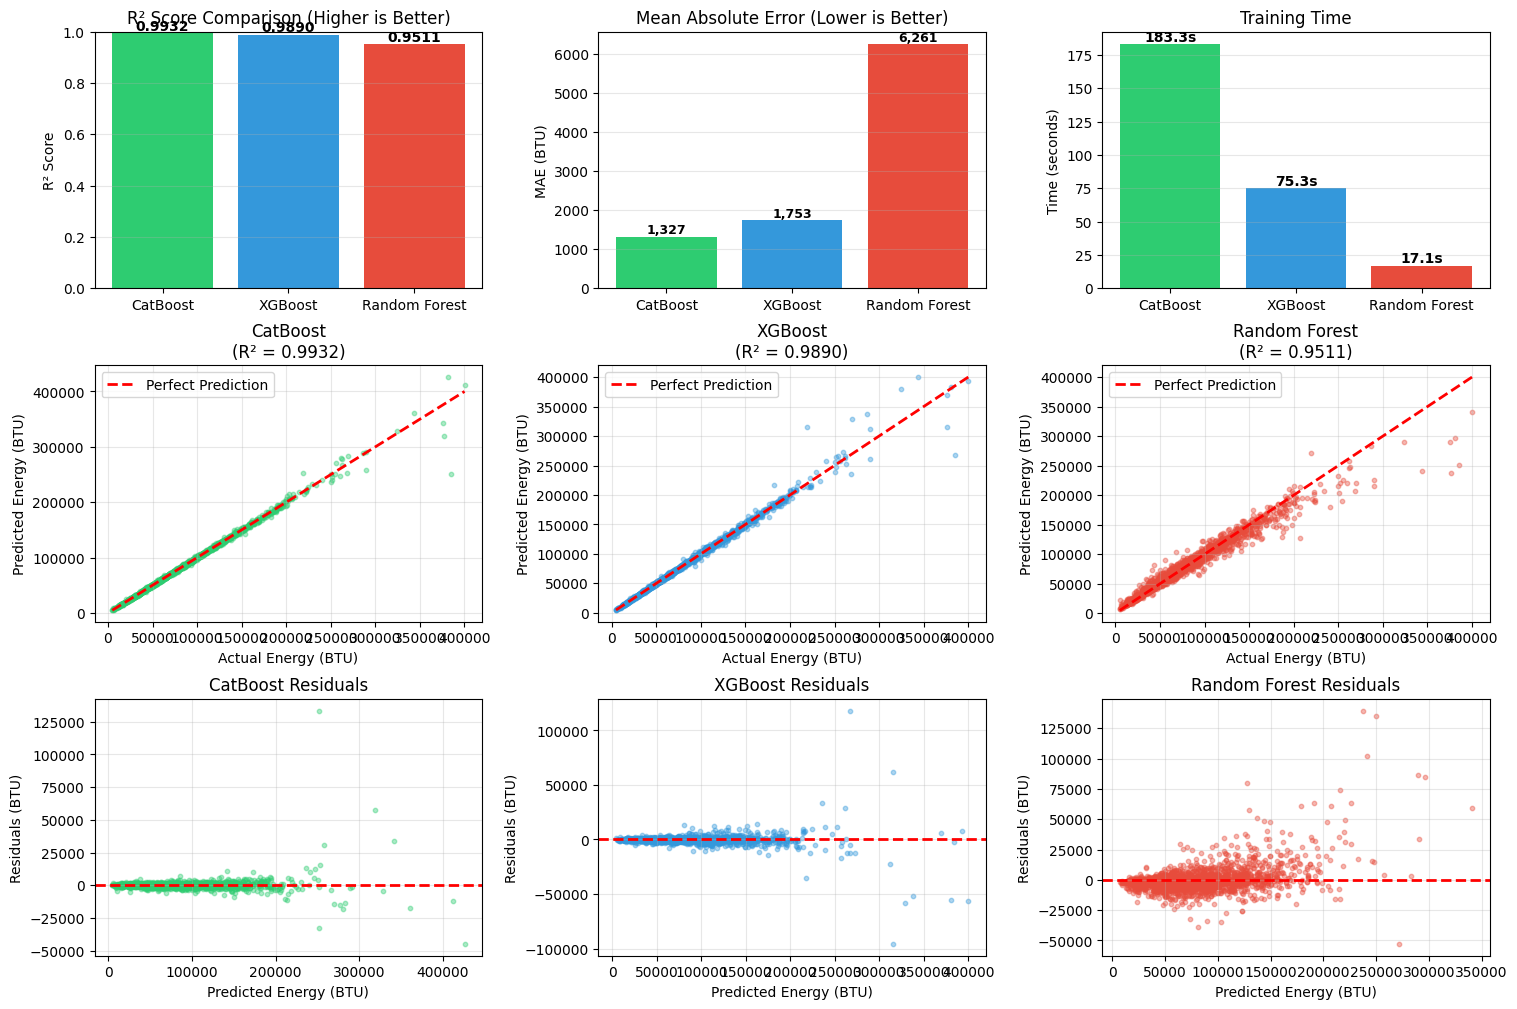

In [ ]:



fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: R² Comparison
ax1 = fig.add_subplot(gs[0, 0])
bars = ax1.bar(results_df['Model'], results_df['R2'], color=['#2ecc71', '#3498db', '#e74c3c'])
ax1.set_ylabel('R² Score')
ax1.set_title('R² Score Comparison (Higher is Better)')
ax1.set_ylim([0, 1])
ax1.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: MAE Comparison
ax2 = fig.add_subplot(gs[0, 1])
bars = ax2.bar(results_df['Model'], results_df['MAE'], color=['#2ecc71', '#3498db', '#e74c3c'])
ax2.set_ylabel('MAE (BTU)')
ax2.set_title('Mean Absolute Error (Lower is Better)')
ax2.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Plot 3: Training Time
ax3 = fig.add_subplot(gs[0, 2])
bars = ax3.bar(results_df['Model'], results_df['Training_Time'], color=['#2ecc71', '#3498db', '#e74c3c'])
ax3.set_ylabel('Time (seconds)')
ax3.set_title('Training Time')
ax3.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}s', ha='center', va='bottom', fontweight='bold')

# Plots 4-6: Actual vs Predicted for each model
colors = ['#2ecc71', '#3498db', '#e74c3c']
for idx, (model_name, color) in enumerate(zip(results_df['Model'], colors)):
    ax = fig.add_subplot(gs[1, idx])
    y_pred = predictions[model_name]
    
    ax.scatter(y_test, y_pred, alpha=0.4, s=10, color=color)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
            'r--', lw=2, label='Perfect Prediction')
    
    r2 = results_df[results_df['Model'] == model_name]['R2'].values[0]
    ax.set_xlabel('Actual Energy (BTU)')
    ax.set_ylabel('Predicted Energy (BTU)')
    ax.set_title(f'{model_name}\n(R² = {r2:.4f})')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Plots 7-9: Residual plots for each model
for idx, (model_name, color) in enumerate(zip(results_df['Model'], colors)):
    ax = fig.add_subplot(gs[2, idx])
    y_pred = predictions[model_name]
    residuals = y_test - y_pred
    
    ax.scatter(y_pred, residuals, alpha=0.4, s=10, color=color)
    ax.axhline(y=0, color='r', linestyle='--', lw=2)
    
    ax.set_xlabel('Predicted Energy (BTU)')
    ax.set_ylabel('Residuals (BTU)')
    ax.set_title(f'{model_name} Residuals')
    ax.grid(True, alpha=0.3)

plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("Visualizations saved as 'model_comparison.png'")
plt.show()

7. FEATURE IMPORTANCE COMPARISON (Top 15)


FEATURE IMPORTANCE COMPARISON
Feature importance comparison saved as 'feature_importance_comparison.png'


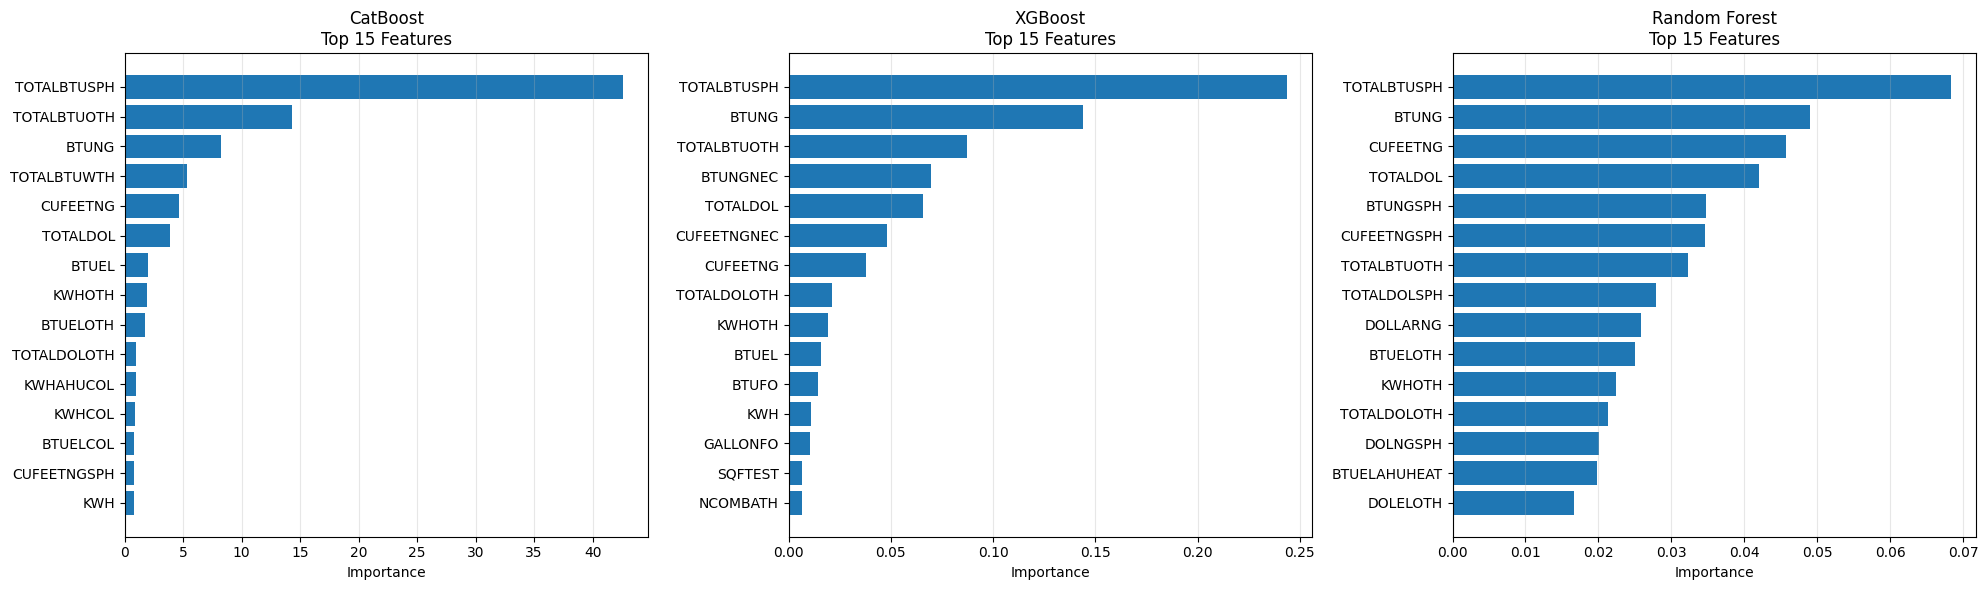

In [ ]:


fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, model_name in enumerate(results_df['Model']):
    model = models[model_name]['model']
    
    # Get feature importances
    if model_name == 'CatBoost':
        importances = model.feature_importances_
    elif model_name == 'Random Forest':
        importances = model.feature_importances_
    else:  # XGBoost
        importances = model.feature_importances_
    
    # Create dataframe
    feature_imp = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importances
    }).sort_values('importance', ascending=False).head(15)
    
    # Plot
    axes[idx].barh(range(15), feature_imp['importance'])
    axes[idx].set_yticks(range(15))
    axes[idx].set_yticklabels(feature_imp['feature'])
    axes[idx].set_xlabel('Importance')
    axes[idx].set_title(f'{model_name}\nTop 15 Features')
    axes[idx].invert_yaxis()
    axes[idx].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('feature_importance_comparison.png', dpi=300, bbox_inches='tight')
print("Feature importance comparison saved as 'feature_importance_comparison.png'")
plt.show()


8. SAVE DETAILED RESULTS


In [ ]:
# Save comparison results
results_df.to_csv('model_comparison_results.csv', index=False)
print("\nDetailed results saved as 'model_comparison_results.csv'")

# Save predictions for further analysis
predictions_df = pd.DataFrame({
    'Actual': y_test.values,
    **{f'{name}_Predicted': pred for name, pred in predictions.items()}
})
predictions_df.to_csv('model_predictions_comparison.csv', index=False)
print("Predictions saved as 'model_predictions_comparison.csv'")

print("\n" + "="*80)
print("COMPARISON COMPLETE!")
print("="*80)